In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import bioread as br
import bids

from glob import glob
import scipy.signal as signal
from sklearn.metrics import normalized_mutual_info_score, pairwise_distances, pairwise_distances_chunked
#from tslearn.metrics import dtw

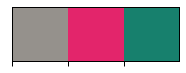

In [2]:
sns.set_context('paper', font_scale=3)

pal = sns.crayon_palette(['Gray', 'Razzmatazz', 'Tropical Rain Forest'])
sns.set_palette(pal)
sns.palplot(pal)

In [3]:
pd.options.mode.chained_assignment = None

def consecutive(data, stepsize=0.000501):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(f0, data, Q, fs):
    #nyquist = fs / 2
    #f0 = notch
    w0 = f0 / nyquist
    if fs % w0 != 0:
        filtered = data.copy()
        for i in np.arange(1, (nyquist / f0)):
            #print(notches[notch] * i)
            f = f0 * i
            b,a = signal.iirnotch(w0, Q)
            filtered = signal.filtfilt(b, a, filtered)
    b,a = signal.iircomb(w0, Q, ftype='notch', fs=fs)
    filtered = signal.filtfilt(b, a, data)
    return filtered


In [4]:
br.__version__

'2.1.3'

# Electrocardiogram data
## Single-band, single-echo EPI sequence

In [5]:
bids.BIDSLayout('/Users/katherine.b/Dropbox/Data/ds001242/', derivatives=True)

BIDS Layout: ...herine.b/Dropbox/Data/ds001242 | Subjects: 52 | Sessions: 0 | Runs: 256

In [6]:
data_fname = '/Users/katherine.b/Dropbox/Projects/physio/mbme-physio-denoising/example_data/4232_2_Musser_K23_redux.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/katherine.b/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [7]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Digital' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel

In [8]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [9]:
#from Erica Musser's K23 EIRT sequence
slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = data.samples_per_second

nyquist = fs/2
Q = 10

### Fourier transform of ECG recording in absence of MR sequence

In [10]:
fft_ecg = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000])
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000].shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


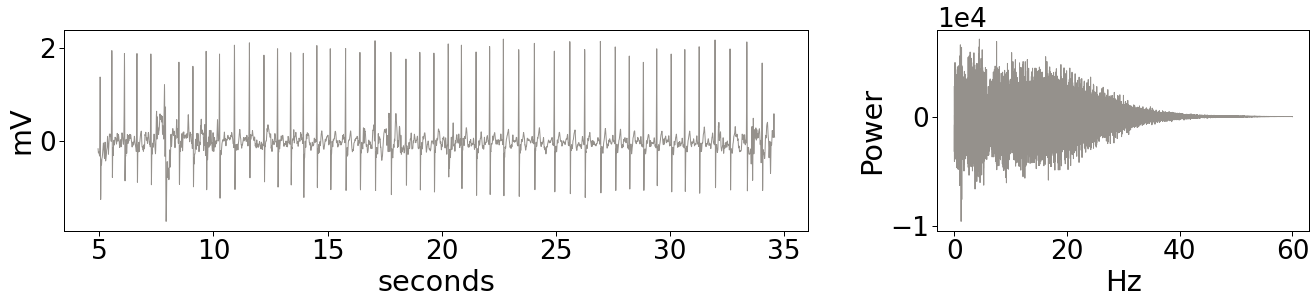

In [11]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=2)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[1000:7000], 
             signal.decimate(timeseries['ECG'][:200000], 10)[1000:7000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_ecg.real[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')

ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-ecg_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [12]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(i, np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

{0: 5.5885, 1: 5.595258333333334, 2: 5.592233333333334, 3: 5.563108333333333, 4: 5.001758333333333, 5: 5.001774999999999}


In [13]:
scan1 = timeseries[timeseries.index.isin(scan_idx[1])]
time = scan1['seconds'].values

In [14]:
f, Cxy = signal.coherence(scan1['ECG'], 
                          timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          fs=fs, nperseg=10000)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


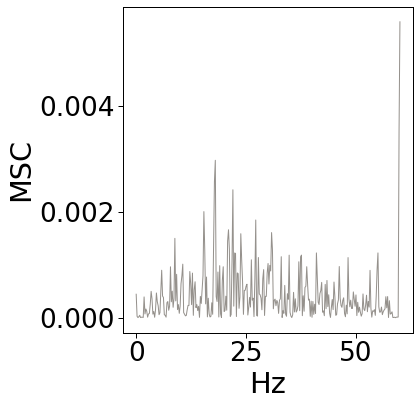

In [15]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgRaw.png'.format(out_dir, basename, i), 
            dpi=300, 
            bbox_inches='tight')

In [16]:
fft_ecg = np.fft.fft(scan1['ECG'].values)
freq = np.fft.fftfreq(scan1['ECG'].values.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=300)

In [17]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/katherine.b/Library/Python/3.8/lib/python/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


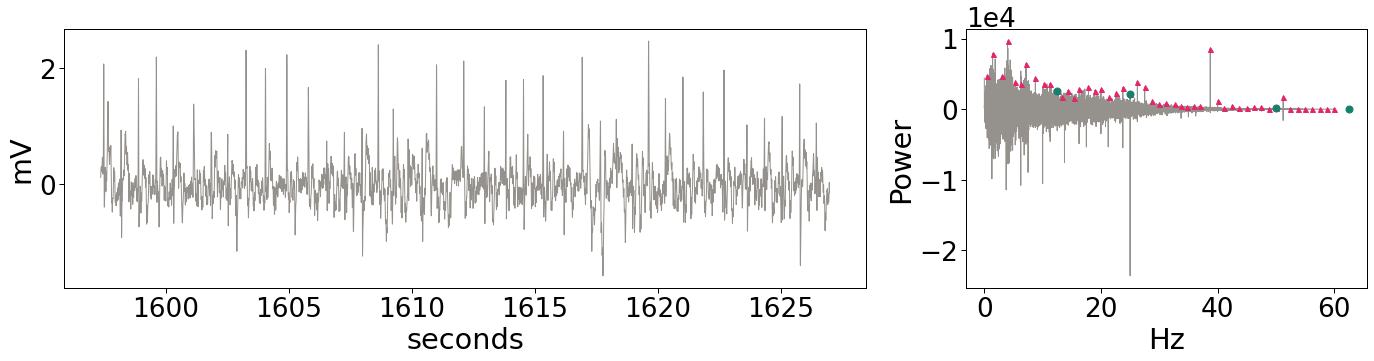

In [18]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(scan1['ECG'], 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_ecg.real[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:50], fft_ecg.real[peaks][:50], "^", ms=5)
ax2.plot(freq[slice_peaks][:4], fft_ecg.real[slice_peaks][:4], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_ecg-raw.png'.format(out_dir, basename, i), dpi=300)

In [19]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / tr
filtered = comb_band_stop(notch, scan1['ECG'], Q, 2000.)
f, Cxy = signal.coherence(scan1['ECG'], filtered, fs=data.samples_per_second, nperseg=10000)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

ValueError: fs must be divisible by w0.

In [ ]:
fs / (notch / nyquist)

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBioPacClean.png'.format(out_dir, basename, i), 
            dpi=300,
            bbox_inches='tight')

In [ ]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          filtered, 
                          fs=data.samples_per_second, 
                          nperseg=10000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBioPacClean.png'.format(out_dir, basename, i), dpi=300, 
            bbox_inches='tight')

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_filt.real[:limit], linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-ecg_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

In [ ]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / mb / tr
filtered1 = comb_band_stop(notch, scan1['ECG'], Q, fs)
f, Cxy = signal.coherence(scan1['ECG'], filtered1, fs=data.samples_per_second, nperseg=10000)

fft_filt = np.fft.fft(filtered1)
freq = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBottenClean.png'.format(out_dir, basename, i), dpi=300, 
            bbox_inches='tight')

In [ ]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          filtered1, 
                          fs=data.samples_per_second, 
                          nperseg=10000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBottenClean.png'.format(out_dir, basename, i), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
f, Cxy = signal.coherence(filtered, filtered1, fs=data.samples_per_second, nperseg=10000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgBioPacCleanXecgBottenClean.png'.format(out_dir, basename, i), 
            dpi=300, 
            bbox_inches='tight')

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered1, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_filt.real[:limit], linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-ecg_BottenClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

## Multiband, multi-echo EPI sequence

In [ ]:
data_fname = '/Users/katherine.b/Dropbox/Projects/physio/mbme-physio-denoising/example_data/sub-Blossom_ses-01.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/katherine.b/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [ ]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Trigger' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel


In [ ]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [ ]:
#arranging noisy frequencies to be filtered out
slices = 48
tr = 1.5
mb = 3
cutoff = 120

fs = data.samples_per_second

#I don't know if this is right, been playing around with the value of Q
Q = 100

nyquist = fs/2

In [ ]:
fft_ecg = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000])
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['ECG'][:1000000].shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[1000:7000], 
             signal.decimate(timeseries['ECG'][:200000], 10)[1000:7000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_ecg.real[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')

ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-ecg_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [ ]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

In [ ]:
scan1 = timeseries[timeseries.index.isin(scan_idx[0])]
time = scan1['seconds'].values

In [ ]:
f, Cxy = signal.coherence(scan1['ECG'], 
                          timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          fs=data.samples_per_second, nperseg=10000)

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgRaw.png'.format(out_dir, basename, i), dpi=300, bbox_inches='tight')

In [ ]:
fft_ecg = np.fft.fft(scan1['ECG'].values)
freq = np.fft.fftfreq(scan1['ECG'].values.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_ecg))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_ecg.real[:30000], distance=150)

In [ ]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(scan1['ECG'], 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_ecg_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_ecg.real[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:220], fft_ecg.real[peaks][:220], "^", ms=5)
ax2.plot(freq[slice_peaks], fft_ecg.real[slice_peaks], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_ecg-raw.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
fs / 16

### Filtering with BioPac recommendations
Note 242 suggests filtering slices/TR

In [ ]:
notch = slices / tr
filtered = comb_band_stop(16, scan1['ECG'], Q, fs)
f, Cxy = signal.coherence(scan1['ECG'], filtered, fs=data.samples_per_second, nperseg=10000)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBioPacClean.png'.format(out_dir, basename, i), dpi=300, bbox_inches='tight')

In [ ]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          filtered, 
                          fs=data.samples_per_second, nperseg=10000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBioPacClean.png'.format(out_dir, basename, i), dpi=300, bbox_inches='tight')

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_filt.real[:limit], linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-ecg_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

### Filtering with the Bottenhorn Recommendations

In [ ]:
notches = {'slices': slices / mb / tr, 
           'tr': 1 / tr}

#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
filtered1 = scan1['ECG']
for notch in notches:
    filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

fft_filt1 = np.fft.fft(filtered1)
freq1 = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_ecg_db = 10 * np.log10(abs(fft_filt1))
limit = np.where(freq1 >= 60)[0][0]

In [ ]:
f, Cxy = signal.coherence(scan1['ECG'], filtered1, fs=data.samples_per_second, nperseg=10000)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgRawXecgBottenClean.png'.format(out_dir, basename, i), dpi=300, bbox_inches='tight')

In [ ]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['ECG'], 
                          filtered1, 
                          fs=data.samples_per_second, nperseg=10000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgNoMRIXecgBottenClean.png'.format(out_dir, basename, i), dpi=300, bbox_inches='tight')

In [ ]:
f, Cxy = signal.coherence(filtered, 
                          filtered1, 
                          fs=data.samples_per_second, nperseg=10000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 60], Cxy[f <= 60], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-ecgBioPacCleanXecgBottenClean.png'.format(out_dir, basename, i), dpi=300, bbox_inches='tight')

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered1, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq1[:limit], abs(fft_filt.real[:limit]), linewidth=1, ax=ax2)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

#fig.savefig('{0}/figures/{1}-scan{2}-ecg_BottenClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

In [ ]:
np.corrcoef(fft_filt.real[:33822], fft_filt1.real[:33822])

# EDA!

In [ ]:
data_fname = '/Users/katherine.b/Dropbox/Projects/physio/mbme-physio-denoising/example_data/4232_2_Musser_K23_redux.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/katherine.b/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [ ]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Digital' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel

In [ ]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [ ]:
#from Erica Musser's K23 EIRT sequence
slices = 60
tr = 0.8
mb = 6
cutoff = 120

fs = data.samples_per_second

nyquist = fs/2
Q = 100

In [ ]:
fft_eda = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000])
P_bar_eda_noEpi = np.mean(fft_eda)
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000].shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[1000:7000], 
             signal.decimate(timeseries['EDA'][:200000], 10)[1000:7000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db.real[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')

ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-eda_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [ ]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

In [ ]:
scan1 = timeseries[timeseries.index.isin(scan_idx[1])]
time = scan1['seconds'].values

In [ ]:
f, Cxy = signal.coherence(scan1['EDA'], 
                          timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          fs=data.samples_per_second, nperseg=100000)

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaRaw.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
fft_eda = np.fft.fft(scan1['EDA'].values)
freq = np.fft.fftfreq(scan1['EDA'].values.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_eda.real[:30000], distance=300)

In [ ]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)


In [ ]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(scan1['EDA'], 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_eda_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_eda_db[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:50], fft_eda_db[peaks][:50], "^", ms=5)
ax2.plot(freq[slice_peaks], fft_eda_db[slice_peaks], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_eda-raw.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / tr
filtered = comb_band_stop(notch, scan1['EDA'], Q, fs)
f, Cxy = signal.coherence(scan1['EDA'], filtered, fs=data.samples_per_second, nperseg=100000)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)

ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          filtered, fs=data.samples_per_second, nperseg=100000)

fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-eda_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

In [ ]:
#hp_ecg = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
notch = slices / mb / tr
filtered1 = comb_band_stop(notch, scan1['EDA'], Q, fs)
f, Cxy = signal.coherence(scan1['EDA'], filtered1, fs=data.samples_per_second, nperseg=100000)

fft_filt = np.fft.fft(filtered1)
freq = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered1, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}-scan{2}-eda_BottenClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['EDA'], filtered1, 
                          fs=data.samples_per_second, nperseg=100000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))

fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
f, Cxy = signal.coherence(filtered, filtered1, fs=data.samples_per_second, nperseg=100000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)

ax.set_xlabel('Hz')
ax.set_ylabel('MSC')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))

fig.savefig('{0}/figures/{1}-scan{2}-edaBioPacCleanXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

## Multiband, multiecho BOLD EPI sequence

In [ ]:
data_fname = '/Users/katherine.b/Dropbox/Projects/physio/mbme-physio-denoising/example_data/sub-Blossom_ses-01.acq'
data = br.read_file(data_fname)
basename = data_fname.split('/')[-1][:-4]
out_dir = '/Users/katherine.b/Dropbox/Projects/physio/physio-note'

if not os.path.exists('{0}/data'.format(out_dir)):
    os.mkdir('{0}/data'.format(out_dir))
    os.mkdir('{0}/data/clean'.format(out_dir))
    os.mkdir('{0}/data/raw'.format(out_dir))
    os.mkdir('{0}/figures'.format(out_dir))

In [ ]:
for channel in data.named_channels:
    #print(channel)
    if 'ECG' in channel:
        ecg_channel = channel
    elif 'Trigger' in channel:
        trigger = channel
    elif 'EDA' in channel:
        eda_channel = channel
    elif 'Respiration' in channel:
        resp_channel = channel


In [ ]:
timeseries = pd.DataFrame(columns=['ECG', 'EDA', 'Trigger', 'Resp', 'seconds'])

timeseries['Trigger'] = data.named_channels[trigger].data
timeseries['ECG'] = data.named_channels[ecg_channel].data
timeseries['EDA'] = data.named_channels[eda_channel].data
timeseries['Resp'] = data.named_channels[resp_channel].data
timeseries['seconds'] = data.time_index
timeseries.to_csv('{0}/data/raw/{1}-raw.csv'.format(out_dir, basename))

#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
fives = timeseries[timeseries['Trigger'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)

In [ ]:
#arranging noisy frequencies to be filtered out
slices = 48
tr = 1.5
mb = 3
cutoff = 120

fs = data.samples_per_second

#I don't know if this is right, been playing around with the value of Q
Q = 100

nyquist = fs/2

In [ ]:
fft_eda = np.fft.fft(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000])
freq = np.fft.fftfreq(timeseries[timeseries['Trigger'] != 5]['EDA'][:1000000].shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(timeseries['seconds'][:200000],10)[:6000], 
             signal.decimate(timeseries['EDA'][:200000], 10)[:6000], 
             linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], 
             fft_eda_db[:limit], 
             ax=ax2, linewidth=1)#bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')

ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-eda_raw-noepi.png'.format(out_dir, basename), dpi=300)

In [ ]:
scans = {}
for i in range(len(scan_idx)):
    duration = len(scan_idx[i])/2000./60
    #print(np.round(duration, 1), 'minutes')
    if duration > 2.:
        scans[i] = duration
print(scans)

In [ ]:
scan1 = timeseries[timeseries.index.isin(scan_idx[0])]
time = scan1['seconds'].values

In [ ]:
f, Cxy = signal.coherence(scan1['EDA'], 
                          timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          fs=data.samples_per_second, nperseg=100000)

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <0 0.5], Cxy[f <= 0.5], linewidth=1)

ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaRaw.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
fft_eda = np.fft.fft(scan1['EDA'].values)
freq = np.fft.fftfreq(scan1['EDA'].values.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda))
limit = np.where(freq >= 60)[0][0]

peaks, _ = signal.find_peaks(fft_eda.real[:30000], distance=150)

In [ ]:
slice_peaks = []
slice_freq = slices / mb / tr
for peak in peaks:
    remainder = np.round(freq[peak],2) % np.round(slice_freq, 2)
    #print(freq[peak], slice_freq, remainder)
    if np.isclose(remainder, 0, atol=1e-2) or np.isclose(remainder, slice_freq, atol=1e-1):
        slice_peaks.append(peak)

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5))
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(scan1['EDA'], 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
#sns.lineplot(freq[:100000], fft_eda_db[:100000], linewidth=1, ax=ax2)
sns.lineplot(freq[:limit], 
            fft_eda_db.real[:limit], 
            ax=ax2, linewidth=1) #bottom subplot
ax2.plot(freq[peaks][:220], fft_eda_db.real[peaks][:220], "^", ms=5)
ax2.plot(freq[slice_peaks], fft_eda_db.real[slice_peaks], "o", ms=7)
ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')

fig.savefig('{0}/figures/{1}_scan-{2}_eda-raw.png'.format(out_dir, basename, i), dpi=300)

### BioPac recommendations

In [ ]:
notch = slices / tr
filtered = comb_band_stop(notch, scan1['EDA'], Q, fs)
f, Cxy = signal.coherence(scan1['EDA'], filtered, fs=data.samples_per_second, nperseg=100000)

fft_filt = np.fft.fft(filtered)
freq = np.fft.fftfreq(filtered.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)

ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_eda_db.real[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-scan{2}-eda_BioPacClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()

### Bottenhorn recommendations

In [ ]:
notches = {'slices': slices / mb / tr, 
           'tr': 1 / tr}

#hp_eda = butter_highpass_filter(scan1['ECG'], 1, fs, order=5)
filtered1 = scan1['EDA']
for notch in notches:
    filtered1 = comb_band_stop(notches[notch], filtered1, Q, fs)

f, Cxy = signal.coherence(scan1['EDA'], filtered1, fs=data.samples_per_second, nperseg=100000)

fft_filt = np.fft.fft(filtered1)
freq = np.fft.fftfreq(filtered1.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_filt))
limit = np.where(freq >= 60)[0][0]

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaRawXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
f, Cxy = signal.coherence(timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          filtered, 
                          fs=data.samples_per_second, nperseg=100000)
fig,ax = plt.subplots(figsize=(6,6))
plt.tight_layout()
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBioPacClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
f, Cxy = signal.coherence(filtered1, 
                          timeseries[timeseries['Trigger'] != 5]['EDA'], 
                          fs=data.samples_per_second, nperseg=100000)

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
plt.tight_layout()
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaNoMRIXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
f, Cxy = signal.coherence(filtered1, 
                          filtered, 
                          fs=data.samples_per_second, nperseg=100000)

In [ ]:
fig,ax = plt.subplots(figsize=(6,6))
sns.lineplot(f[f <= 0.5], Cxy[f <= 0.5], linewidth=1)
plt.tight_layout()
ax.set_xlabel('Hz')
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax.set_ylabel('MSC')
fig.savefig('{0}/figures/{1}-scan{2}-edaBioPacCleanXedaBottenClean.png'.format(out_dir, basename, i), dpi=300)

In [ ]:
gridkw = dict(width_ratios=[2,1])
fig,(ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,5), sharex='col')
plt.tight_layout(pad=1)

sns.lineplot(signal.decimate(scan1['seconds'], 10)[:6000], 
            signal.decimate(filtered1, 10)[:6000], 
            linewidth=1, ax=ax1) #array, top subplot
sns.lineplot(freq[:limit], fft_eda_db.real[:limit], linewidth=1, ax=ax2)

ax1.set_xlabel('seconds')
ax1.set_ylabel('mV')
ax2.set_xlabel('Hz')
ax2.ticklabel_format(axis='y', style='sci', scilimits=(-1,1))
ax2.set_ylabel('Power')
fig.savefig('{0}/figures/{1}-scan{2}-eda_BottenClean.png'.format(out_dir, basename, i), dpi=300)
#plt.close()